In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

## 1.0: General Overview of the Dataset and its Features

In [3]:
df = pd.read_csv("./train.csv")

### 1.1: First few observations and the dataframe's shape

In [4]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
df.shape

(1460, 81)

We have 1460 observations in the training dataset and 81 features. 

### 1.2: What about missing values? How many are there? Where are they concentrated?

In [6]:
df.isna().sum().sum()

6965

In [7]:
df.isna().sum().sort_values(ascending = False).head(15)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
dtype: int64

There seems to be about 6965 missing values focused on optional additions to a house like pools, fences, firplaces, garages, basements, and miscellaneous features. 

### 1.3: Breakdown Of Predictive Features

In [8]:
## Splitting the features of the dataset into distinct classes
noms = ['MSSubClass','MSZoning', 'Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']

ords = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','CentralAir']

continuous = ['LotFrontage','MasVnrArea']

discrete = ['LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','OverallQual','OverallCond','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars', 'YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']

## Leftover features not included in the prior categories (consists of Id and SalePrice)
rest = [item for item in list(df.columns) if item not in list(noms + ords + continuous + discrete)]

An example of each of the different variable types (nominal, ordinal, discrete, and continuous) found within the dataset:

In [9]:
df[['Neighborhood','ExterQual','LotFrontage','LotArea']].head()

Neighborhood ExterQual  LotFrontage  LotArea
0      CollgCr        Gd         65.0     8450
1      Veenker        TA         80.0     9600
2      CollgCr        Gd         68.0    11250
3      Crawfor        TA         60.0     9550
4      NoRidge        Gd         84.0    14260

We have different labels, shown by the Neighborhood feature, several ranking systems, and numerical measurements of different fixtures within the house (both as floats and as integers). Of the four types of features, which are most prominent?

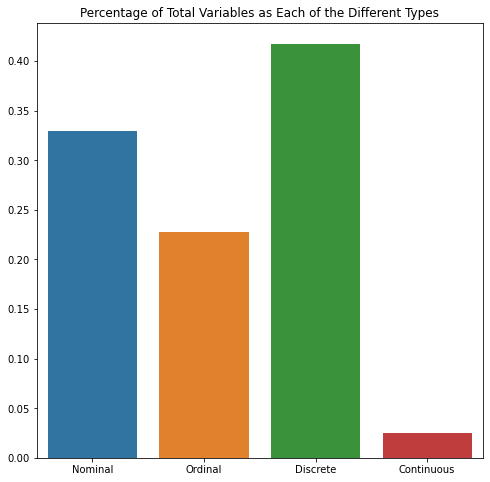

In [10]:
total = len(noms + ords + continuous + discrete)
plt.figure(figsize=(8,8))
sns.barplot(['Nominal','Ordinal','Discrete','Continuous'], [(len(noms) / total), (len(ords)/total),(len(discrete)/total),(len(continuous)/total)])
plt.title("Percentage of Total Variables as Each of the Different Types");


In [11]:
df[['Neighborhood','ExterQual','LotFrontage','LotArea']].dtypes

Neighborhood     object
ExterQual        object
LotFrontage     float64
LotArea           int64
dtype: object

The majority of features are categorical; these often need to be converted into a more descriptive datatype (turning the general object into a date or numerical value) during the cleaning phase. Of course, the discrete variables are represented by integers, and those continuous utilize float values.

### 1.4: Statistical Summary of the Numerical Variables

In [12]:
df[discrete + continuous].describe()

LotArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  \
count    1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    10516.828082   443.639726    46.549315   567.240411  1057.429452   
std      9981.264932   456.098091   161.319273   441.866955   438.705324   
min      1300.000000     0.000000     0.000000     0.000000     0.000000   
25%      7553.500000     0.000000     0.000000   223.000000   795.750000   
50%      9478.500000   383.500000     0.000000   477.500000   991.500000   
75%     11601.500000   712.250000     0.000000   808.000000  1298.250000   
max    215245.000000  5644.000000  1474.000000  2336.000000  6110.000000   

          1stFlrSF     2ndFlrSF    GrLivArea   GarageArea   WoodDeckSF  ...  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1162.626712   346.992466  1515.463699   472.980137    94.244521  ...   
std     386.587738   436.528436   525.480383   213.804841   125.338794  ...   
min     334.000000     0.000000   334.000000     0.000000     0.000000  ...   
25%     882.000000     0.000000  1129.500000   334.500000     0.000000  ...   
50%    1087.000000     0.000000  1464.000000   480.000000     0.000000  ...   
75%    1391.250000   728.000000  1776.750000   576.000000   168.000000  ...   
max    4692.000000  2065.000000  5642.000000  1418.000000   857.000000  ...   

       TotRmsAbvGrd   Fireplaces   GarageCars    YearBuilt  YearRemodAdd  \
count   1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean       6.517808     0.613014     1.767123  1971.267808   1984.865753   
std        1.625393     0.644666     0.747315    30.202904     20.645407   
min        2.000000     0.000000     0.000000  1872.000000   1950.000000   
25%        5.000000     0.000000     1.000000  1954.000000   1967.000000   
50%        6.000000     1.000000     2.000000  1973.000000   1994.000000   
75%        7.000000     1.000000     2.000000  2000.000000   2004.000000   
max       14.000000     3.000000     4.000000  2010.000000   2010.000000   

       GarageYrBlt       MoSold       YrSold  LotFrontage   MasVnrArea  
count  1379.000000  1460.000000  1460.000000  1201.000000  1452.000000  
mean   1978.506164     6.321918  2007.815753    70.049958   103.685262  
std      24.689725     2.703626     1.328095    24.284752   181.066207  
min    1900.000000     1.000000  2006.000000    21.000000     0.000000  
25%    1961.000000     5.000000  2007.000000    59.000000     0.000000  
50%    1980.000000     6.000000  2008.000000    69.000000     0.000000  
75%    2002.000000     8.000000  2009.000000    80.000000   166.000000  
max    2010.000000    12.000000  2010.000000   313.000000  1600.000000  

[8 rows x 35 columns]

Although there is much to take in here, there are important aspects of this dataset to note. First, many features represent optional housing fixtures, which many observations chose to do without. This results in a case where the mean is often a lower value than the standard deviation. See the WoodDeckSF histogram below for an example.

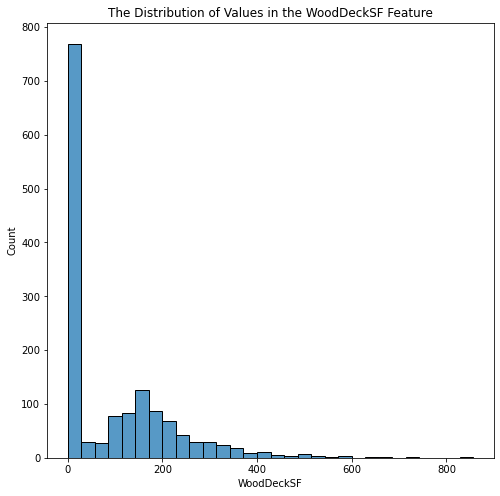

In [13]:
plt.figure(figsize=(8,8))
sns.histplot(df, x="WoodDeckSF", bins=30)
plt.title("The Distribution of Values in the WoodDeckSF Feature");

### 1.5: We are trying to predict the sales price (a continuous variable) of houses in the testing dataset. What does its distribution look like?

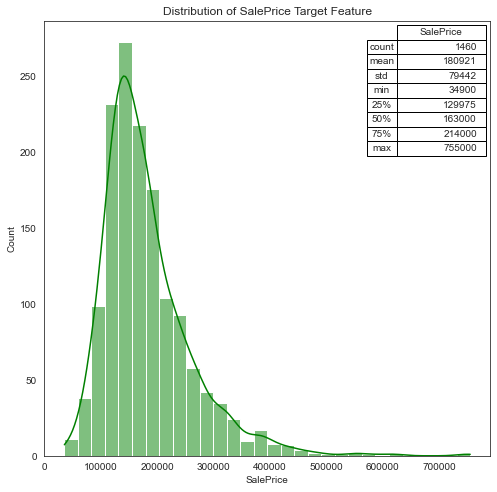

In [14]:
summary = df[['SalePrice']].describe().astype('int32')

sns.set_palette(sns.color_palette("pastel"))
sns.set_style('white')
plt.figure(figsize=(8,8))
plt.title("Distribution of SalePrice Target Feature")
sns.histplot(data = df, x = "SalePrice", bins=30, kde=True, color='green')
plt.table(cellText=summary.values, rowLabels=summary.index, colLabels=summary.columns, cellLoc='right', rowLoc='center', loc='right', bbox=[0.79, 0.69, 0.2, 0.3]);

There is a clear right skew in the Sales Prices of these homes. Beyond that, there seem to be a few outliers at the extreme right. Both of these issues should be addressed. 

### 1.6: Train-Validation Test Split

In [191]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(columns=['SalePrice'])
y = df[['SalePrice']]

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=2)
for train_index, test_index in split.split(df,df['Neighborhood']):
    Xtrain = X.loc[train_index]
    ytrain = y.loc[train_index]
    Xval = X.loc[test_index]
    yval = y.loc[test_index]


This would be the right time to split the data into training and validation sets. I chose to perform a stratified split based on the neighborhood each home was located in. There are a few rare labels in the feature, and it has a clear impact on SalePrice, so I felt that it was necessary.

## 2.0: Comparing the Colinearity of the Differing Features

### 2.1: Creating a Heat Map

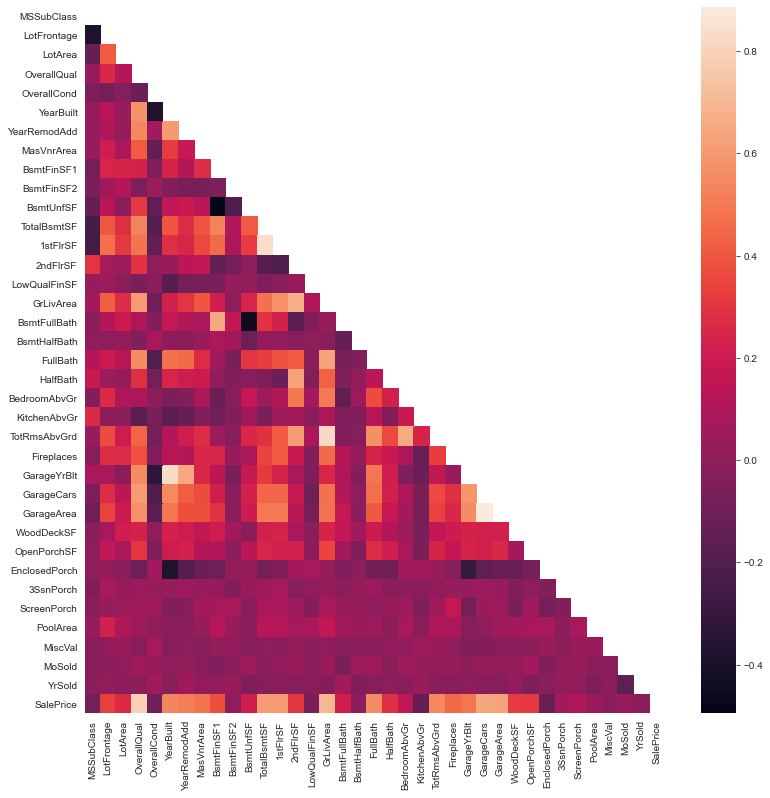

In [16]:
plt.figure(figsize=(13,13))
sns.heatmap(pd.concat((Xtrain.drop('Id', axis = 1), ytrain), axis = 1).corr(), mask = np.triu(pd.concat((Xtrain.drop('Id', axis = 1), ytrain), axis = 1).corr()));

From the looks of it, all of the strong and notable features have a positive connection with the sales price of a house. Below I will gather those relationships are healthy and could not have been made by chance (p-value <= 0.05).

In [17]:
temp = pd.concat((Xtrain[continuous + discrete], ytrain['SalePrice']), axis = 1).dropna()
# Initialize a dictionary that consists of column_name: (p-value, correlation coefficient)
h1 = {}
for column in temp:
    # For each column in that dataset above, calculate the p-value and correlation coefficient, if p is less than 0.05, and the coefficient is > 0.3, keep and display it
    corr, pval = pearsonr(temp[column], temp['SalePrice'])
    if abs(corr) >= 0.2 and pval <= 0.05:
        h1[column] = [pval, corr]

h2 = pd.DataFrame(h1).T
h2.columns = ['p-value','correlation coefficient']
h2.sort_values('p-value', ascending=False).head(10)

p-value  correlation coefficient
BsmtUnfSF     7.930831e-11                 0.214852
BsmtFullBath  5.629863e-12                 0.227307
HalfBath      1.994635e-16                 0.269807
LotArea       7.826218e-19                 0.289934
2ndFlrSF      3.148014e-19                 0.293091
LotFrontage   1.790504e-24                 0.331665
WoodDeckSF    2.633308e-25                 0.337303
OpenPorchSF   1.570114e-29                 0.364257
BsmtFinSF1    1.150727e-32                 0.382712
Fireplaces    1.635827e-44                 0.443491

The dictionary above represents those features that had a p-value greater than 0.05 and a correlation coefficient greater than 0.3. The latter states that the pair of features            (x and SalePrice) holds a strong relationship, and the former measures whether or not it is statistically significant. Once those hurdles are cleared (and as long as these features do not correlate with each other to a great degree), we can move on. 

### 2.2: Choosing Discrete and Continuous Features

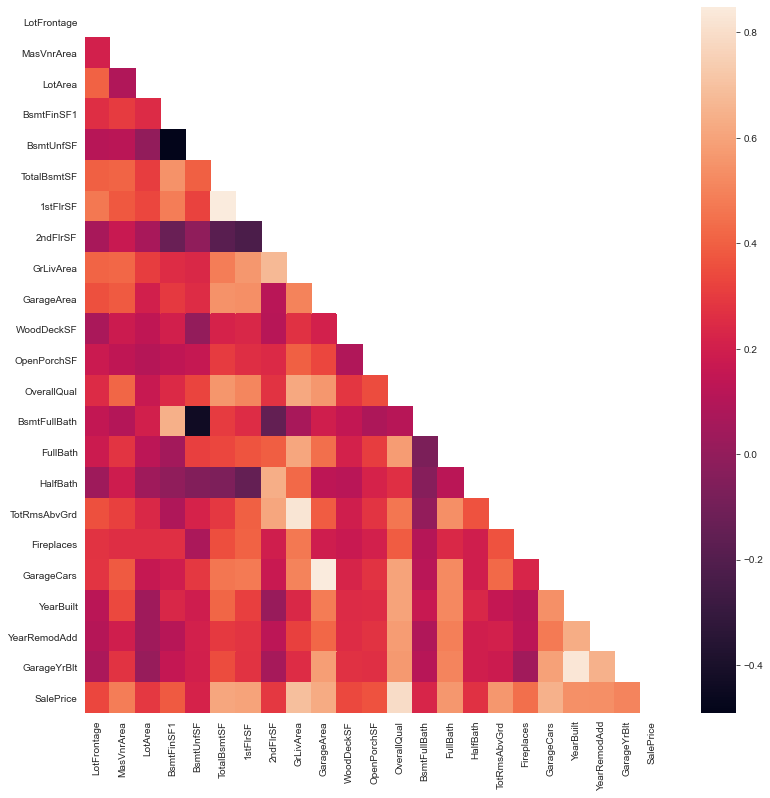

In [18]:
predictive = temp.corr()[h1.keys()]
index = temp.corr()[h1.keys()].columns
heat = predictive.loc[index]

plt.figure(figsize=(13,13))
sns.heatmap(heat, mask = np.triu(heat));

We see that a couple of the features are correlated with each other such as the number of cars in the garage and its size; with that said their correlation coefficient is not greater than 0.9, meaning that there is still a sizeable amount of information that is independent. Let's take a look a few of these features and visualize how they realte to SalePrie. 

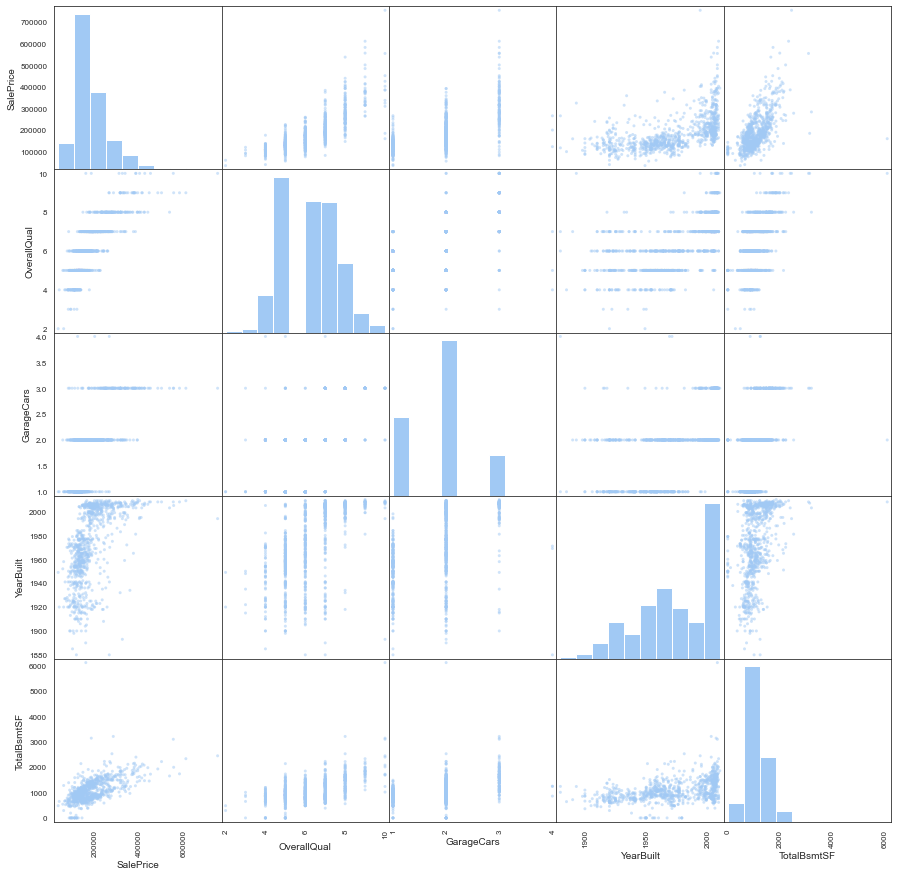

In [19]:
from pandas.plotting import scatter_matrix

attr = ['SalePrice','OverallQual','GarageCars','YearBuilt','TotalBsmtSF']
scatter_matrix(temp[attr], figsize=(15,15));


If you look at the top row of the scatter matrix, you can see the positive relationship between SalePrice and the other highly predictive features. They make a certain amount of sense too; improved quality, more luxurious and spacious additions (like basements and garages), and newer buildings would often sell for more than their competitors. 

## 3.0: Feature Engineering

### 3.1: Missing Values

Missing values in this dataset are not random; instead they signal that the observation does not have the optional addon that is being measured. The simple solution here is to create a 'None' label, which holds that information. That said, this strategy only works for categorical features.

In [20]:
def catna(df):
    concat = list(noms + ords)
    df[concat] = df[concat].fillna('None')
    return df

Missing values become a problem for discrete features like 'GarageYrBlt', which has 81 nonrandom missing values (i.e. there are 81 records without a garage). 

The choices here are simple but frustrating: 

1. We either remove those observations (removing data should obviously be avoided).

2. We fill in the values with an aggregate like the median of said group. 

I chose the latter, despite the fact that these observations clearly don't have a garage; the BuildingType attribute's labels served to group the missing values well, so I found the found the median of each 'group' and assigned that value. 

In [21]:
def impute_garage_year_built(df):

    ## Finding the median values
    one_fam_garage_year = df['GarageYrBlt'][df['BldgType'] == '1Fam'].median()
    duplex_garage_year = df['GarageYrBlt'][df['BldgType'] == 'Duplex'].median()
    two_fmCon_garage_year = df['GarageYrBlt'][df['BldgType'] == '2fmCon'].median()
    twnhs_garage_year = df['GarageYrBlt'][df['BldgType'] == 'Twnhs'].median()
    twnhsE_garage_year = df['GarageYrBlt'][df['BldgType'] == 'TwnhsE'].median()

    ## Filling missing values with the median
    df['GarageYrBlt'][df['BldgType'] == 'Duplex'] = df['GarageYrBlt'][df['BldgType'] == 'Duplex'].fillna(duplex_garage_year)
    df['GarageYrBlt'][df['BldgType'] == '1Fam'] = df['GarageYrBlt'][df['BldgType'] == '1Fam'].fillna(one_fam_garage_year)
    df['GarageYrBlt'][df['BldgType'] == '2fmCon'] = df['GarageYrBlt'][df['BldgType'] == '2fmCon'].fillna(two_fmCon_garage_year)
    df['GarageYrBlt'][df['BldgType'] == 'Twnhs'] = df['GarageYrBlt'][df['BldgType'] == 'Twnhs'].fillna(twnhs_garage_year)
    df['GarageYrBlt'][df['BldgType'] == 'TwnhsE'] = df['GarageYrBlt'][df['BldgType'] == 'TwnhsE'].fillna(twnhsE_garage_year)
    return df

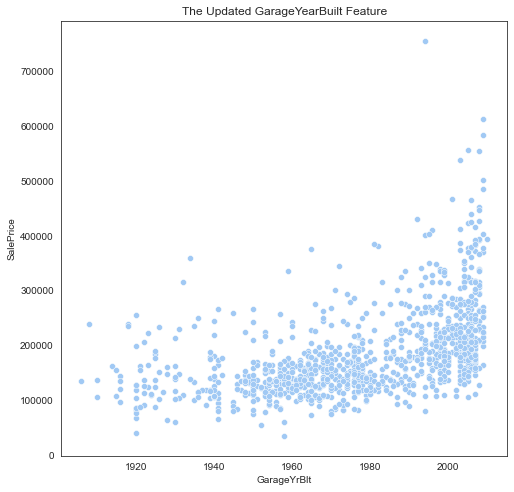

In [22]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = pd.concat((Xtrain, ytrain), axis=1), x = 'GarageYrBlt', y = 'SalePrice')
plt.title("The Updated GarageYearBuilt Feature");

There is a downside to this strategy in that many of these garage-free records are worth less than their counterparts, and now they are given a year built value. If you look at the vertical line near x value of 1980, there is a clear effect from this strategy. If there were more missing values, I'd be more worried, but this is admittedly a suboptimal solution. 

In [23]:
Xtrain.isna().sum().sort_values(ascending = False).head()

PoolQC         1163
MiscFeature    1126
Alley          1096
Fence           938
FireplaceQu     558
dtype: int64

This leaves two sources of missing values, LotFrontage and MasVnrArea, continuous features that DO seem to have a small number of random missing values. I will simply have them filled in by their median value in the numeric pipeline.

### 3.2: Outliers

In [24]:
ytrain['SalePrice'].sort_values(ascending = False).head(10)

691     755000
898     611657
803     582933
1046    556581
440     555000
769     538000
178     501837
798     485000
1373    466500
1243    465000
Name: SalePrice, dtype: int64

The two outliers I found are homes that sold for more than 100,000 dollars more than their nearest competitors (greater than 700000 dollars total), which are more grouped together with the rest of the observations. These values are extreme to the point that they would almost definitely having an outsized influence on the model, so they should be removed. 

In [25]:
def drop_outliers(df):
    outliers = list(ytrain[ytrain['SalePrice'] > 700000].index)
    print('Found {0} outliers!'.format(len(outliers)))
    if outliers:
        df.drop(outliers, axis = 0, inplace = True)
    return df

### 3.3: SalePrice - Skewed Target Feature

As shown in 1.5, the target feature has a right skew; I'll address this through the use of a log transformation, which should normalize its values. 

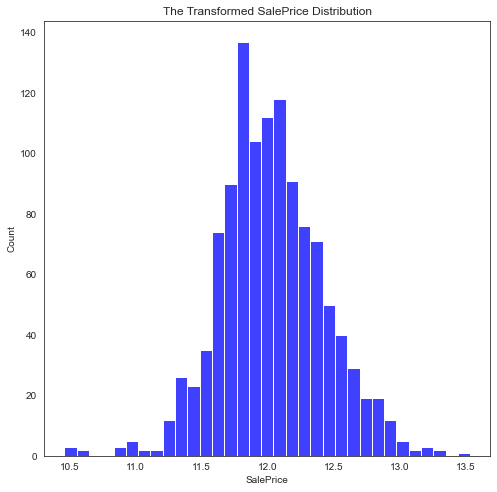

In [26]:
def target_transformation(df, set_type = 'not'):
    if set_type == 'training':
        df = drop_outliers(df)
    df['SalePrice'] = df['SalePrice'].transform(np.log)
    return df

plt.figure(figsize = (8,8))
sns.histplot(ytrain['SalePrice'].transform(np.log), color = 'blue')
plt.title("The Transformed SalePrice Distribution");

Beautiful.

### 3.4: Dropping Features

We will be removing the following attributes for these reasons:

1. Utilities - 'binary' attribute with one label

2. Street - paved label has >97% of the total observations

3. Condition2 - norm label has 99% of the total observations

4. Roof Material - compshg label has 98% of the total records

5. Heating - heated homes make up 97% of the total

6. MiscFeature - 96% of the total are missing values

7. PoolQC - 99% of total are missing values

8. Id - Has no value

In [27]:
def drop_features(df):
    df.drop(['Id', 'Utilities','Street','Condition2','RoofMatl','Heating','MiscFeature','PoolQC'], axis = 1, inplace = True)
    return df


if "Utilities" in noms:
    noms.remove('Utilities')
if "Street" in noms:
    noms.remove('Street')
if 'Condition2' in noms:
    noms.remove('Condition2')
if 'RoofMatl' in noms:
    noms.remove('RoofMatl')
if 'Heating' in noms:
    noms.remove('Heating')
if 'MiscFeature' in noms:
    noms.remove('MiscFeature')
if 'PoolQC' in ords:
    ords.remove('PoolQC')

### 3.5: Numeric Pipeline

In addition to filling in any missing values with the median, the numeric pipeline will standardize the data by using the StandardScaler; this method is more resistant to outliers than MinMaxScaler. 

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std', StandardScaler())
    ])

We will also check the VIF value for the selected numerical features to see if any are multicollinear, so we can perhaps solve that problem. 

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif = pd.DataFrame()
    vif['features'] = df.columns

    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)


temp = list(h2.index)
temp.pop()
temp_df = Xtrain[temp].dropna()
calculate_vif(temp_df).sort_values('VIF',ascending = False).head()

features           VIF
21   GarageYrBlt  23667.136042
19     YearBuilt  20029.368380
20  YearRemodAdd  12654.027010
8      GrLivArea   1563.308818
6       1stFlrSF    964.092961

We aim for the VIF value to be below 10, so this result is problematic. Let's remove and combine the features shown.

In [30]:
Xtrain['MeanYearOfImprovements'] = Xtrain[['GarageYrBlt','YearRemodAdd','YearBuilt']].mean(axis = 1)
temp_df['MeanYearOfImprovements'] = temp_df[['GarageYrBlt','YearRemodAdd','YearBuilt']].mean(axis = 1)
temp_df.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'], axis = 1, inplace = True)


temp_df['MeanSquareFootage'] = temp_df[['GrLivArea','1stFlrSF','2ndFlrSF','GarageArea','TotalBsmtSF']].mean(axis = 1)
temp_df.drop(['GrLivArea','1stFlrSF','2ndFlrSF','GarageArea','TotalBsmtSF'], axis = 1, inplace = True)

vif_heat = Xtrain.drop(['GarageYrBlt','YearRemodAdd','YearBuilt'], axis = 1)
calculate_vif(temp_df).sort_values('VIF',ascending = False).head(10)

features         VIF
15       MeanSquareFootage  102.669503
11            TotRmsAbvGrd   58.407126
7              OverallQual   56.084514
14  MeanYearOfImprovements   43.574114
9                 FullBath   19.572466
13              GarageCars   17.641568
0              LotFrontage   13.821644
4                BsmtUnfSF    9.685816
3               BsmtFinSF1    8.630361
8             BsmtFullBath    3.171241

In [31]:
def change_features(df):
    df['MeanYearOfImprovements'] = df[['GarageYrBlt','YearRemodAdd','YearBuilt']].mean(axis = 1)
    df.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'], axis = 1, inplace = True)
    df['MeanSquareFootage'] = df[['GrLivArea','1stFlrSF','2ndFlrSF','GarageArea','TotalBsmtSF']].mean(axis = 1)
    df.drop(['GrLivArea','1stFlrSF','2ndFlrSF','GarageArea','TotalBsmtSF'], axis = 1, inplace = True)

    return df

### 3.6: Categorical Pipeline

We now need to condense some of the categorical variable labels to reduce the overall dimensionality of both sets and to allow the label encoder to function on both sets (having a rare label increases the odds of it not being accounted for in the training set)

I'm going to aim for having each label account for about at least 5% of the overall records.

In [32]:
## Function used to help visualize

def cat_check(col): 
    covered = df[col].fillna('None')
    print(covered.value_counts()/len(df), "\n")
    plt.figure(figsize = (5,5))
    sns.boxplot(covered, df['SalePrice'])
    plt.title("{} Distribution".format(col));
    return

### 3.6.1: MSSubClass

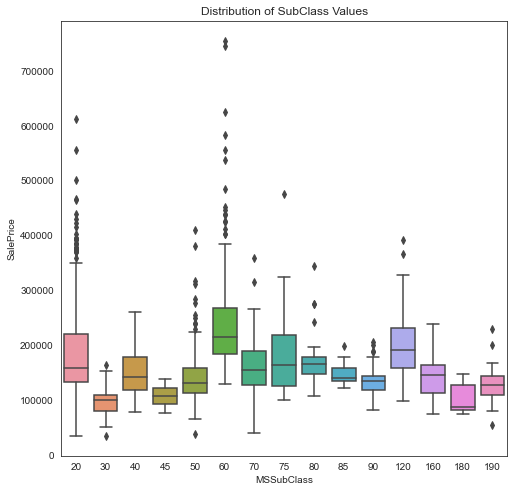

In [33]:
plt.figure(figsize = (8,8))
sns.boxplot(df['MSSubClass'], df['SalePrice'])
plt.title("Distribution of SubClass Values");

In [34]:
print((df['MSSubClass'].value_counts()/len(df)).sort_values())

#temp = {190:[180,160, 190], 50:[40, 50], 70:[75, 80, 70], 90:[85, 90], 30:[45,30], 120:[120], 60:[60], 20:[20]}
#df['MSSubClass'] = df['MSSubClass'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

40     0.002740
180    0.006849
45     0.008219
75     0.010959
85     0.013699
190    0.020548
90     0.035616
80     0.039726
70     0.041096
160    0.043151
30     0.047260
120    0.059589
50     0.098630
60     0.204795
20     0.367123
Name: MSSubClass, dtype: float64


The distribution of this feature is pretty scattered; we'll merge smallest subclasses into the larger ones nearby. There's a clear difference between differing classes in this category, so it's definitely worth keeping.

### 3.6.2: MSZoning

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64 



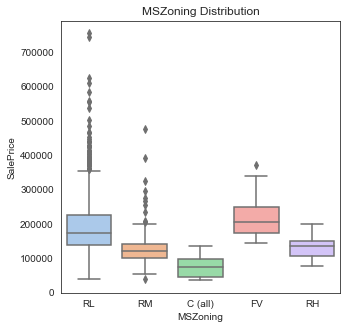

In [35]:
cat_check('MSZoning')

In [36]:
#temp = {'RL':['RL'],'RM':['RM','C (all)'],'FV':['FV','RH']}
#df['MSZoning'] = df['MSZoning'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

We seem to have one dominant label, an alternative, and a set of smaller labels. The latter are clearly differentiated in terms of sale price, but RL and RM both range widely. 

### 3.6.3: Alley

None    0.937671
Grvl    0.034247
Pave    0.028082
Name: Alley, dtype: float64 



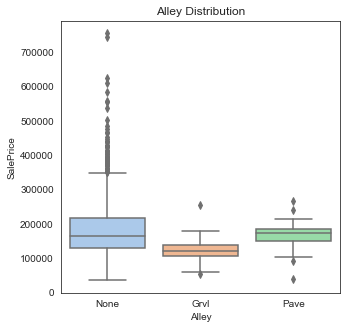

In [37]:
cat_check('Alley')

In [38]:
#df['Alley'] = np.where(df['Alley'] == df['Alley'], 'yes', 'no')

This feature currently distinguishes between paved and gravel alleyways near the household, which causes the gravel alleyway label to be a rare label. There's also no real difference between houses with and without an alley, so its not worth keeping.

### 3.6.4: LotShape

In [39]:
df['LotShape'].fillna('None').value_counts()/len(df)

Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

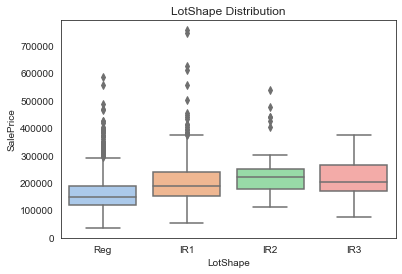

In [40]:
sns.boxplot(df['LotShape'], df['SalePrice'])
plt.title('LotShape Distribution');

In [41]:
#df['LotShape'] = np.where(df['LotShape'] == 'Reg', 'Reg', 'Other')

This one is as easy as can be; we have a dominant label that is quite different from the others. All we have to do there is combine the smaller labels into one.

### 3.6.5: Land Contour

Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64 



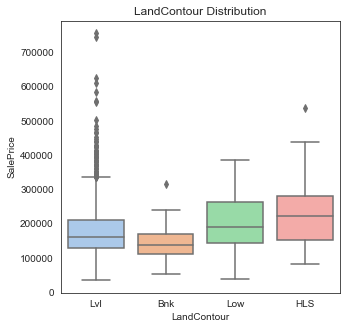

In [42]:
cat_check('LandContour')

In [43]:
#df['LandContour'] = np.where(df['LandContour'] == 'Lvl', 'Lvl', np.where(df['LandContour'] == 'Bnk', 'Bnk', 'Other'))

This is similar to our prior feature in that there is a dominant label and three others that could easily be combined. With that being said, the three smaller labels are different enough that I will combine 'Low' and 'HLS' and leave 'BNK' alone.

### 3.6.6: LotConfig

Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64 



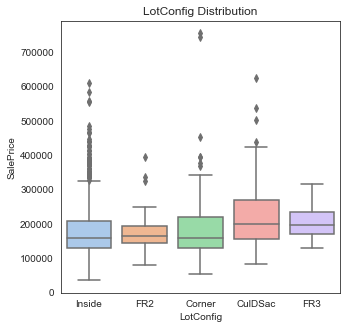

In [44]:
cat_check('LotConfig')

In [45]:
#df['LotConfig'] = np.where(df['LotConfig'] == 'Inside', 'Inside', np.where(df['LotConfig'] == 'Corner', 'Corner', 'Other'))

This feature seems relatively flat, but there is not too much of a need for change. I'll combine FR2 and FR3, the lowest percentage labels that are essentially the same.

### 3.6.7: LandSlope

Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64 



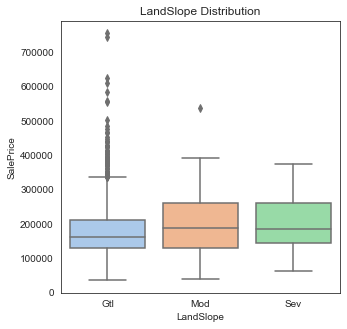

In [46]:
cat_check('LandSlope')

In [47]:
#df['LandSlope'] = np.where(df['LandSlope'] == 'Gtl', 'Gtl', 'Other')

LandSlope is also lopsided. We'll need to combine the smaller two labels.

### 3.6.8: Neighborhood

In [48]:
print(df['Neighborhood'].fillna('None').value_counts()/len(df))

NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
SWISU      0.017123
StoneBr    0.017123
MeadowV    0.011644
Blmngtn    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: Neighborhood, dtype: float64


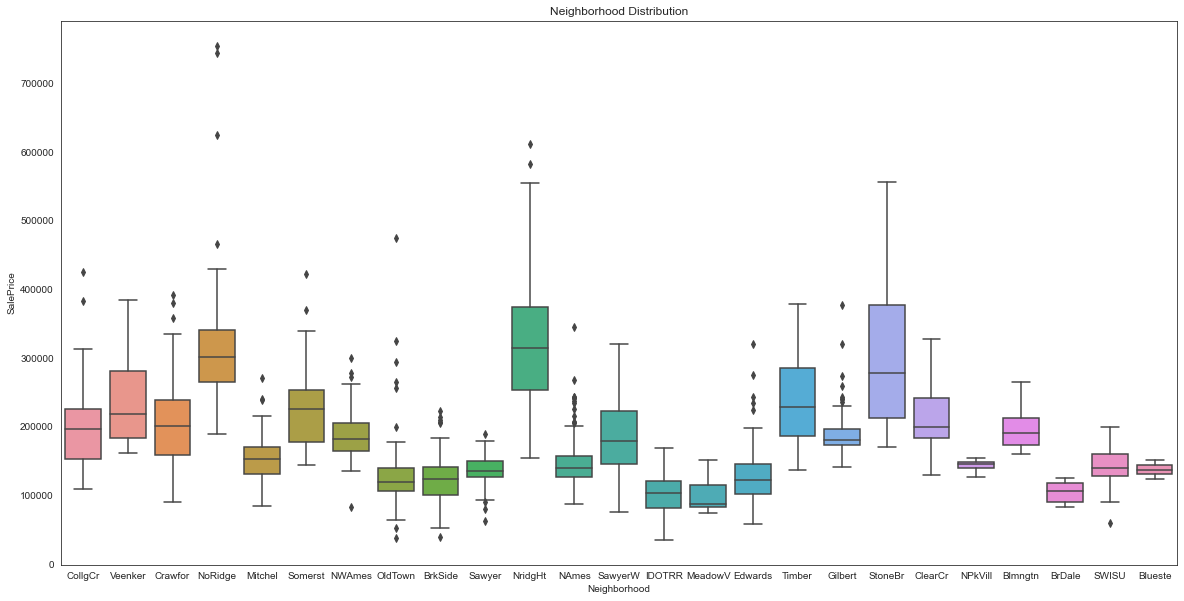

In [49]:
plt.figure(figsize = (20,10))
figure = sns.boxplot(df['Neighborhood'], df['SalePrice'])
plt.title("{} Distribution".format('Neighborhood'));

In [50]:
#temp = {'GroupA':['OldTown','BrkSide','Sawyer','NAmes','IDOTRR','Mitchel','MeadowV','Edwards','NPkVill','BrDale','SWISU','Blueste'], 'GroupB':['CollgCr','Crawfor','NWAmes','Veenker','Somerst','Timber','SawyerW','Gilbert','ClearCr','Blmngtn'], 'GroupC':['NoRidge','NridgHt','StoneBr']}

#df['Neighborhood'] = df['Neighborhood'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

This feature will require work. We have over 10 neighborhoods that represent less than 5% of the total number of observations. We'll group all of the neighborhoods into three different groups.

### 3.6.9: Condition1

Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64 



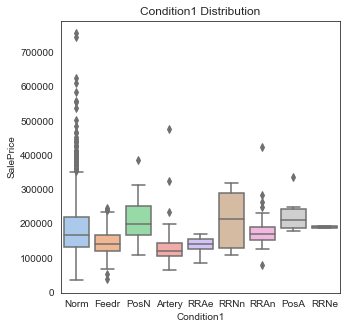

In [51]:
cat_check('Condition1')

In [52]:
#df['Condition1'] = np.where(df['Condition1'] == 'Norm', 'Norm', 'Other')

We have a dominant labels and then a cluster of rare labels. 

### 3.6.10: Building Type

1Fam      0.835616
TwnhsE    0.078082
Duplex    0.035616
Twnhs     0.029452
2fmCon    0.021233
Name: BldgType, dtype: float64 



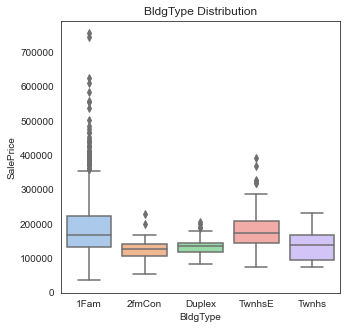

In [53]:
cat_check('BldgType')

In [54]:
#df['BldgType'] = np.where(df['BldgType'] == '1Fam', '1Fam', np.where(df['BldgType'] == 'TwnhsE', 'TwnhsE', 'Other'))

This feature consists of a dominant choice, a secondary label that differentiates itself, and a few smaller labels. We'll merge the small labels together, primarily because they are markedly different to TwinhsE.

### 3.6.11: HouseStyle

1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64 



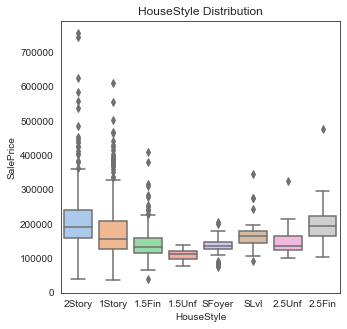

In [55]:
cat_check('HouseStyle')

In [56]:
#temp = {'1Story':['1Story','SLvl'], '2Story':['2Story','2.5Fin'],'1.5Fin':['1.5Fin','1.5Unf','SFoyer','2.5Unf']}

#df['HouseStyle'] = df['HouseStyle'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

This feature was relatively varied, but we needed to merge the rarer labels into their frequently occurring neighbors.

### 3.6.12: RoofStyle

Gable      0.781507
Hip        0.195890
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: RoofStyle, dtype: float64 



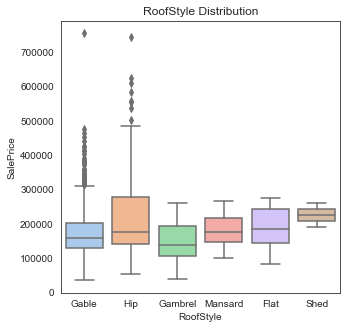

In [57]:
cat_check('RoofStyle')

In [58]:
#df['RoofStyle'] = np.where(df['RoofStyle'] == 'Gable', 'Gable',np.where(df['RoofStyle'] == 'Hip', 'Hip', 'Other'))

There was a dominantly-used label, 'Gable' and a 'Hip' alternative that is likely more expensive (but adds to the value of a home). Then there were the rest that I combined together. 

### 3.6.13: Exterior1st and Exterior2nd

In [59]:
print(df['Exterior1st'].fillna('None').value_counts()/len(df))

VinylSd    0.352740
HdBoard    0.152055
MetalSd    0.150685
Wd Sdng    0.141096
Plywood    0.073973
CemntBd    0.041781
BrkFace    0.034247
WdShing    0.017808
Stucco     0.017123
AsbShng    0.013699
Stone      0.001370
BrkComm    0.001370
CBlock     0.000685
AsphShn    0.000685
ImStucc    0.000685
Name: Exterior1st, dtype: float64


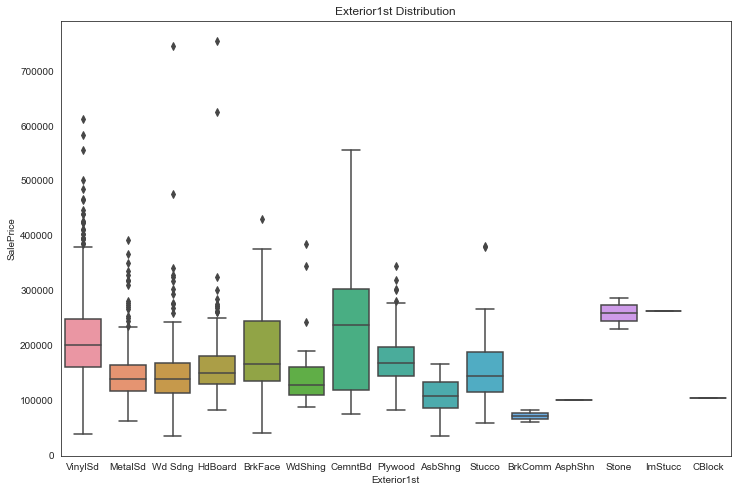

In [60]:
plt.figure(figsize = (12,8))
figure = sns.boxplot(df['Exterior1st'], df['SalePrice'])
plt.title("{} Distribution".format('Exterior1st'));

In [61]:
#temp = {'Group1':['VinylSd','CemntBd','Stone','ImStucc','Plywood','Stucco', 'Other'], 'Group2':['MetalSd','Wd Sdng','HdBoard','BrkFace','WdShing'],'Group3':['AsbShng','BrkComm','AsphShn','CBlock']}
#df['Exterior1st'] = df['Exterior1st'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

In [62]:
print(df['Exterior2nd'].fillna('None').value_counts()/len(df))

VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
Wd Sdng    0.134932
Plywood    0.097260
CmentBd    0.041096
Wd Shng    0.026027
Stucco     0.017808
BrkFace    0.017123
AsbShng    0.013699
ImStucc    0.006849
Brk Cmn    0.004795
Stone      0.003425
AsphShn    0.002055
CBlock     0.000685
Other      0.000685
Name: Exterior2nd, dtype: float64


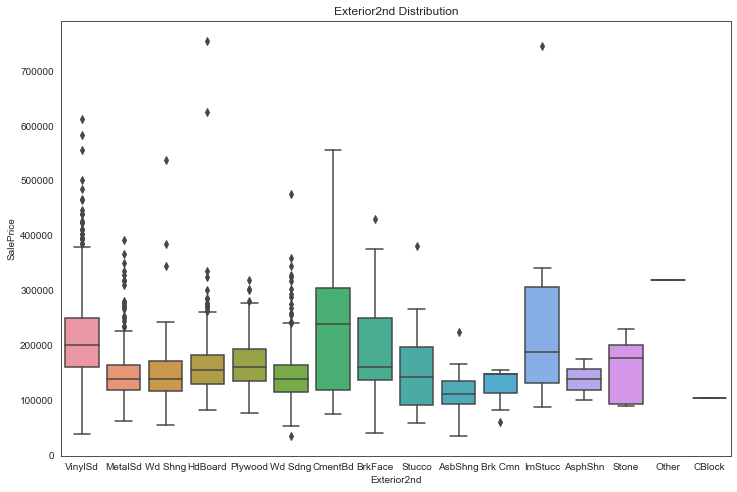

In [63]:
plt.figure(figsize = (12,8))
figure = sns.boxplot(df['Exterior2nd'], df['SalePrice'])
plt.title("{} Distribution".format('Exterior2nd'));

In [64]:
#temp = {'Group1':['VinylSd','CemntBd','CmentBd','Stone','ImStucc','Plywood','Stucco', 'Other'], 'Group2':['MetalSd','Wd Sdng','Wd Shng','HdBoard','BrkFace','WdShing'],'Group3':['AsbShng','Brk Cmn','BrkComm','AsphShn','CBlock']}

#df['Exterior2nd'] = df['Exterior2nd'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Both of these features benefitted from being combined into groups; I had kept the same labels in each group for both features to avoid confusion (and because they fit in both cases).

### 3.6.14: MasVnrType

None       0.597260
BrkFace    0.304795
Stone      0.087671
BrkCmn     0.010274
Name: MasVnrType, dtype: float64 



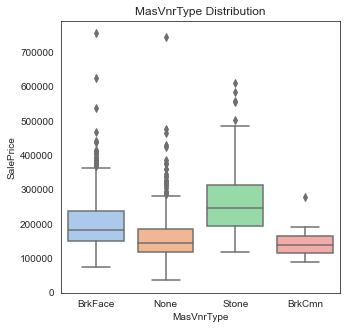

In [65]:
cat_check('MasVnrType')

In [66]:
#df['MasVnrType'] = np.where(df['MasVnrType'] == 'BrkFace', 'BrkFace',np.where(df['MasVnrType'] == 'Stone', 'Stone', 'Other'))

There were only a few options available for this feature; Stone and BrkFace were clearly popular, and I merged the rest into an Other category.

### 6.8.15: Foundation

PConc     0.443151
CBlock    0.434247
BrkTil    0.100000
Slab      0.016438
Stone     0.004110
Wood      0.002055
Name: Foundation, dtype: float64 



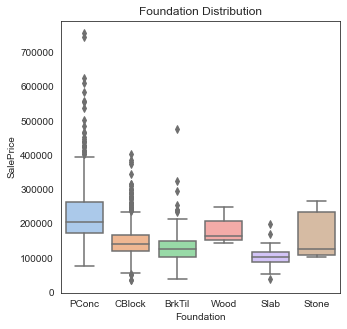

In [67]:
cat_check('Foundation')

In [68]:
#temp = {'Group1':['PConc','Wood'], 'Group2':['CBlock','BrkTil','Slab','Stone']}

#df['Foundation'] = df['Foundation'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

This feature was one of those with a dominant label, an alternative, and then a cluster of relatively unknown options. As usual, I merged them based on their distance.

### 6.8.16: Electrical

SBrkr    0.913699
FuseA    0.064384
FuseF    0.018493
FuseP    0.002055
None     0.000685
Mix      0.000685
Name: Electrical, dtype: float64 



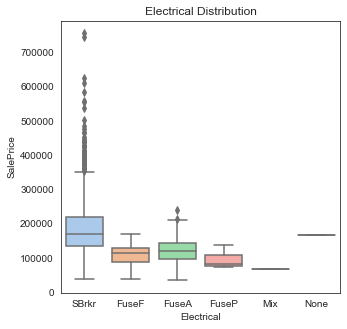

In [69]:
cat_check('Electrical')

In [70]:
#df['Electrical'] = np.where(df['Electrical'] == 'SBrkr', 'SBrkr', 'Other')

Turned this one into a binary feature. You either used a stormbreaker or you did not.

### 6.8.17: GarageType

Attchd     0.595890
Detchd     0.265068
BuiltIn    0.060274
None       0.055479
Basment    0.013014
CarPort    0.006164
2Types     0.004110
Name: GarageType, dtype: float64 



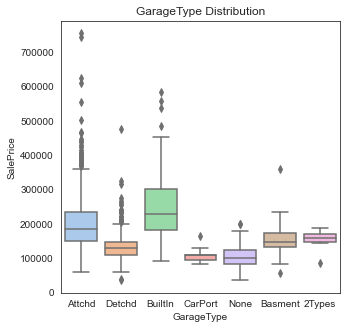

In [71]:
cat_check('GarageType')

In [72]:
#df['GarageType'] = np.where(df['GarageType'] == 'Attchd', 'Attchd', np.where(df['GarageType'] == 'Detchd', 'Detchd', 'Other'))

Three labels here: Dominant, Alternative, the rest. 

### 3.8.18: SaleType

WD       0.867808
New      0.083562
COD      0.029452
ConLD    0.006164
ConLw    0.003425
ConLI    0.003425
CWD      0.002740
Oth      0.002055
Con      0.001370
Name: SaleType, dtype: float64 



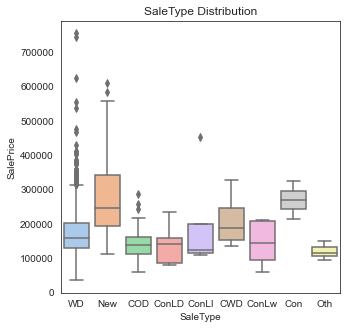

In [73]:
cat_check('SaleType')

In [74]:
#temp = {'Group1':['WD','COD','ConLD','ConLI','ConLw','Oth'], 'Group2':['New','CWD','Con']}

#df['SaleType'] = df['SaleType'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

There were two popular type of sales:'WD' and 'New'. The other labels merged neatly into them. 

### 3.8.19: Sale Conditions

Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64 



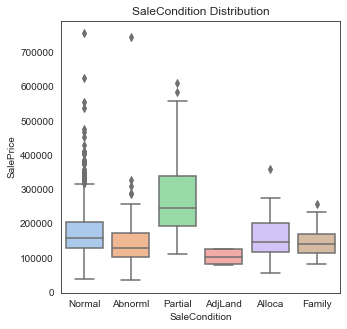

In [75]:
cat_check('SaleCondition')

In [76]:
#df['SaleCondition'] = np.where(df['SaleCondition'] == 'Partial', 'Partial', 'Normal')

This feature was best as a binary option.

### 3.7: Ordinal Pipeline

Now that the categorical pipeline is finished, I have to get rid of the rarer labels in the ordinal pipeline. 

### 3.7.1: Exterior Quality

TA    0.620548
Gd    0.334247
Ex    0.035616
Fa    0.009589
Name: ExterQual, dtype: float64 



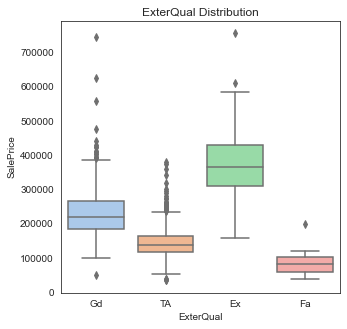

In [77]:
cat_check('ExterQual')

In [78]:
#temp = {'Ex':['Ex'], 'Gd':['Gd'],'TA':['TA','Fa']}

#df['ExterQual'] = df['ExterQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Depending on the feature, some rankings are extremely rare. In this example, exterior quality is rarely rated as 'Fair' since many seem to spruce it up before they try to sell.

### 3.7.2: Exterior Condition

TA    0.878082
Gd    0.100000
Fa    0.019178
Ex    0.002055
Po    0.000685
Name: ExterCond, dtype: float64 



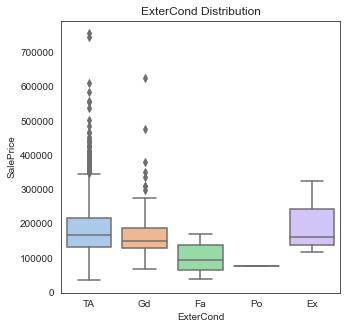

In [79]:
cat_check('ExterCond')

In [80]:
#temp = {'TA':['TA','Fa','Po'], 'Gd':['Gd','Ex']}

#df['ExterCond'] = df['ExterCond'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

There is a similar dynamic here, but we essentially turn this into a binary feature of good and bad.

### 3.7.3: Basement Quality

TA      0.444521
Gd      0.423288
Ex      0.082877
None    0.025342
Fa      0.023973
Name: BsmtQual, dtype: float64 



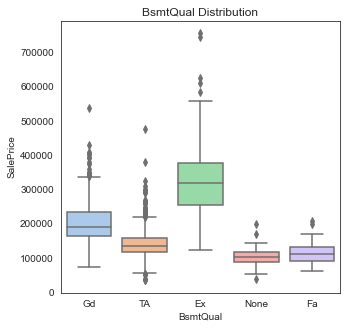

In [81]:
cat_check('BsmtQual')

In [82]:
#temp = {'TA':['TA'],'Fa':['Fa','None',np.nan], 'Gd':['Gd'],'Ex':['Ex']}

#df['BsmtQual'] = df['BsmtQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Missing values featured prevalently in some of these attributes; they were introduced in this one. You'll notice that most features have them rank similarly to items in Fair to Poor condition. 

### 3.7.4: Basement Condition

TA      0.897945
Gd      0.044521
Fa      0.030822
None    0.025342
Po      0.001370
Name: BsmtCond, dtype: float64 



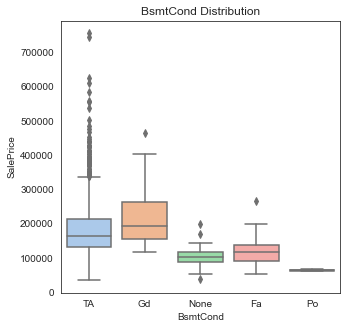

In [83]:
cat_check('BsmtCond')

In [84]:
temp = {'TA':['TA'],'Fa':['Fa','None',np.nan, 'Po'], 'Gd':['Gd']}

#df['BsmtCond'] = df['BsmtCond'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

We simplify this feature to good, medium, and bad.

### 3.7.5: Basement Exposure

No      0.652740
Av      0.151370
Gd      0.091781
Mn      0.078082
None    0.026027
Name: BsmtExposure, dtype: float64 



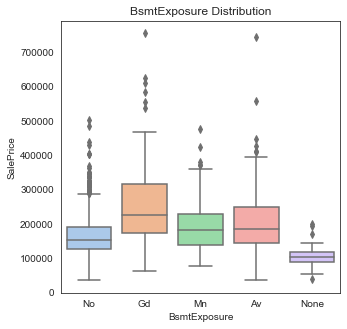

In [85]:
cat_check('BsmtExposure')

In [86]:
#df['BsmtExposure'].fillna('Mn', inplace = True)

Missing values grouped near the 'Mn' label, so I simply imputed them with that value.

### 3.7.6: Basement FinType

Unf     0.294521
GLQ     0.286301
ALQ     0.150685
BLQ     0.101370
Rec     0.091096
LwQ     0.050685
None    0.025342
Name: BsmtFinType1, dtype: float64 



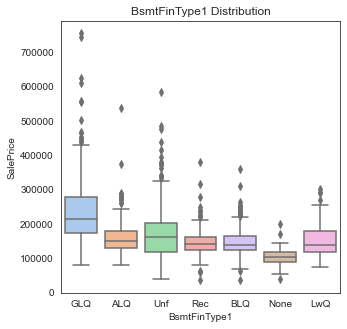

In [87]:
cat_check('BsmtFinType1')

In [88]:
#df['BasmtFinType1'] = np.where(df['BsmtFinType1'] == 'GLQ', 'GLQ', 'Other')

Unf     0.860274
Rec     0.036986
LwQ     0.031507
None    0.026027
BLQ     0.022603
ALQ     0.013014
GLQ     0.009589
Name: BsmtFinType2, dtype: float64 



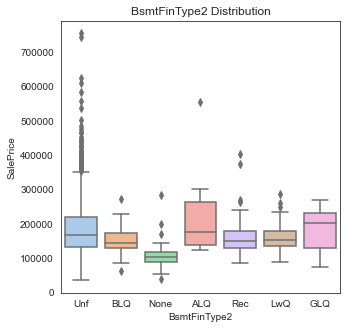

In [89]:
cat_check('BsmtFinType2')

In [90]:
#df['BasmtFinType2'] = np.where(df['BsmtFinType2'] == 'Unf', 'Unf', 'Other')

These features were given differing labels because each of the named options (GLQ and Unf) differentiated themselves in terms of size and price in their respective features. 

### 3.7.7: Heating Quality

Ex    0.507534
TA    0.293151
Gd    0.165068
Fa    0.033562
Po    0.000685
Name: HeatingQC, dtype: float64 



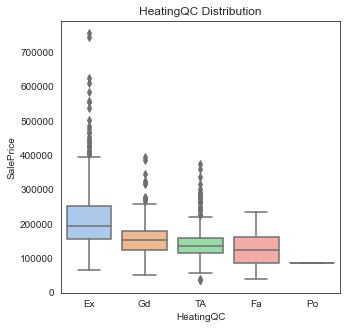

In [91]:
cat_check('HeatingQC')

In [92]:
#temp = {'Ex':['Ex'],'Gd':['Gd'], 'TA':['TA','Fa','Po']}

#df['HeatingQC'] = df['HeatingQC'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Pretty simple. Most values trended higher here, so I had to merge the lower quality heating systems under the 'TA' label.

### 3.7.8: Kitchen Quality

TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: KitchenQual, dtype: float64 



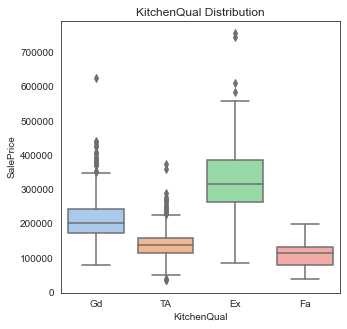

In [93]:
cat_check('KitchenQual')

In [94]:
#temp = {'Ex':['Ex'],'Gd':['Gd'], 'TA':['TA','Fa']}

#df['KitchenQual'] = df['KitchenQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

We had a similar situation here to that above. More good than bad. 

### 3.7.9: Functional

Typ     0.931507
Min2    0.023288
Min1    0.021233
Mod     0.010274
Maj1    0.009589
Maj2    0.003425
Sev     0.000685
Name: Functional, dtype: float64 



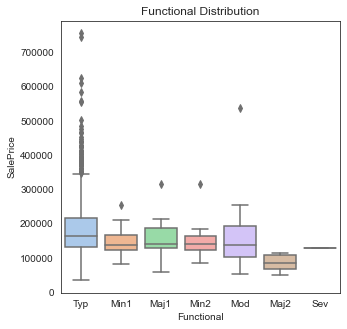

In [95]:
cat_check('Functional')

In [96]:
#df['Functional'] = np.where(df['Functional'] == 'Typ', 'Typ', 'Other')

Turned into a binary feature; "Typ" was the dominant label, and the others had to merge to compete.

### 3.7.10: FirePlace Quality

None    0.472603
Gd      0.260274
TA      0.214384
Fa      0.022603
Ex      0.016438
Po      0.013699
Name: FireplaceQu, dtype: float64 



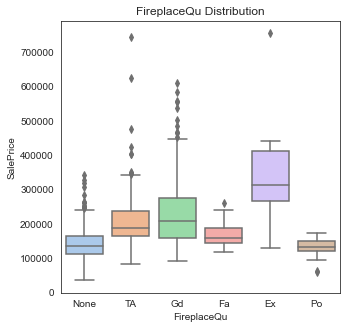

In [97]:
cat_check('FireplaceQu')

In [98]:
#temp = {'Gd':['Ex','Gd'], 'None':['Po', 'None',np.nan], 'TA':['TA','Fa']}

#df['KitchenQual'] = df['KitchenQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Grouping into good, medium, and bad.

### 3.7.11: Garage Finish

Unf     0.414384
RFn     0.289041
Fin     0.241096
None    0.055479
Name: GarageFinish, dtype: float64 



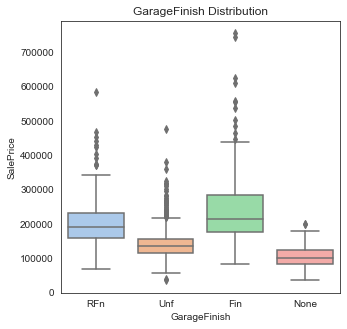

In [99]:
cat_check('GarageFinish')

In [100]:
#temp = {'Fin':['Fin','RFn'], 'Unf':['Unf', 'None',np.nan]}

#df['GarageFinish'] = df['GarageFinish'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Turned to binary; finished or unfinished.

### 3.7.12: Garage Quality

TA      0.897945
None    0.055479
Fa      0.032877
Gd      0.009589
Po      0.002055
Ex      0.002055
Name: GarageQual, dtype: float64 



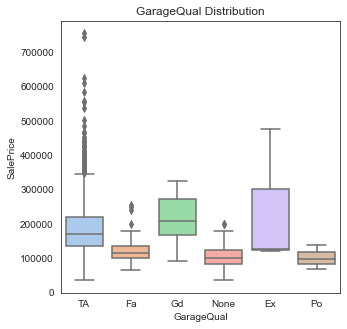

In [101]:
cat_check('GarageQual')

In [102]:
#temp = {'TA':['TA','Gd','Ex'], 'None':['Fa', 'Po','None',np.nan]}

#df['GarageQual'] = df['GarageQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Turned to binary: good or bad.

### 3.7.13: Garage Condition

TA      0.908219
None    0.055479
Fa      0.023973
Gd      0.006164
Po      0.004795
Ex      0.001370
Name: GarageCond, dtype: float64 



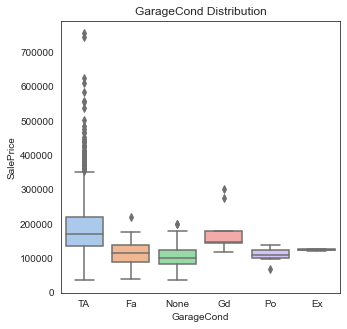

In [103]:
cat_check('GarageCond')

In [104]:
#df['GarageCond'] = np.where(df['GarageCond'] == 'TA', 'TA', 'Other')

The 'TA' Condition was dominant here, and the rest did not differentiate themselves. They were merged together.

### 3.7.14: Paved Driveway

Y    0.917808
N    0.061644
P    0.020548
Name: PavedDrive, dtype: float64 



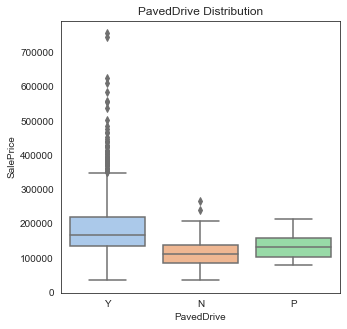

In [105]:
cat_check('PavedDrive')

In [106]:
#df['PavedDrive'] = np.where(df['PavedDrive'] == 'Y', 'Y', 'Other')

Binary: Paved Driveway or not

### 3.7.15: Fence

None     0.807534
MnPrv    0.107534
GdPrv    0.040411
GdWo     0.036986
MnWw     0.007534
Name: Fence, dtype: float64 



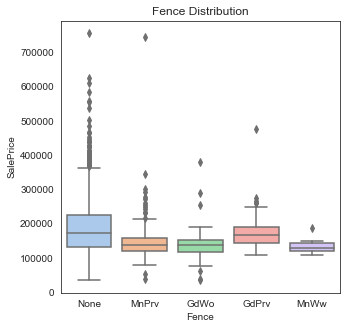

In [107]:
cat_check('Fence')

In [108]:
#temp = {'None':['None',np.nan], 'Exists':['MnPrv', 'GdPrv','GdWo','MnWw']}

#df['Fence'] = df['Fence'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

Binary: fence or no fence

### 3.8: Putting Them All Together

Now that we can transform all of the features, we need to place those unique alterations within two functions, so they could apply to any dataset entered.

### 3.8.1: Categorical and Ordinal Pipeline Construction

In [168]:
cat_attributes = ['MSSubClass','MSZoning','Neighborhood','MasVnrType']

def cat_pipeline(df):
    temp = {190:[180,160, 190], 50:[40, 50], 70:[75, 80, 70], 90:[85, 90], 30:[45,30], 120:[120], 60:[60], 20:[20, 150]}
    df['MSSubClass'] = df['MSSubClass'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])
    temp = {'RL':['RL', 'None'],'RM':['RM','C (all)'],'FV':['FV','RH']}
    df['MSZoning'] = df['MSZoning'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])
    df['MasVnrType'] = np.where(df['MasVnrType'] == 'BrkFace', 'BrkFace',np.where(df['MasVnrType'] == 'Stone', 'Stone', 'Other'))

    return df

ordinal_attributes = ['ExterQual','BsmtQual','HeatingQC','KitchenQual','FireplaceQu']

def ord_pipeline(df):
    temp = {'Ex':['Ex'], 'Gd':['Gd'],'TA':['TA','Fa']}
    df['ExterQual'] = df['ExterQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])
    temp = {'TA':['TA'],'Fa':['Fa','None',np.nan], 'Gd':['Gd'],'Ex':['Ex']}
    df['BsmtQual'] = df['BsmtQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])
    temp = {'Ex':['Ex'],'Gd':['Gd'], 'TA':['TA','Fa','Po']}
    df['HeatingQC'] = df['HeatingQC'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])
    temp = {'Ex':['Ex'],'Gd':['Gd'], 'TA':['TA','Fa', np.nan, 'None']}
    df['KitchenQual'] = df['KitchenQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])
    temp = {'Gd':['Ex','Gd'], 'None':['Po', 'None',np.nan], 'TA':['TA','Fa']}
    df['KitchenQual'] = df['KitchenQual'].apply(lambda row_val: [k for k,v in temp.items() if row_val in v][0])

    return df

### 3.9: Full Pipeline

Now we stitch it all together. 

1. Numerical features have their missing values imputed, and then they are standardized. 

2. Categorical features will be transformed by the above function, and then they are split into binary attributes using the OneHotEncoder class.

3. Ordinal features can be easily ranked, so, after being transformed, they can be changed again this time into numeric values through the OrdinalEncoder class. 

In [110]:
from sklearn.compose import ColumnTransformer

# Specially Picked Features List
num_attributes = list(temp_df.columns)
# Prepare ordinal features by transforming them into numeric values
ordinal_attributes = ['ExterQual','BsmtQual','HeatingQC','KitchenQual','FireplaceQu']
# Split categorical features into many binary attributes
cat_attributes = ['MSSubClass','MSZoning','Neighborhood','MasVnrType']

# pipeline for selected numeric features
partial_pipeline = ColumnTransformer([
    ("num", numeric_pipeline, num_attributes),
    ("ord", OrdinalEncoder(), ordinal_attributes),
    ("cats", OneHotEncoder(), cat_attributes),
])

In [111]:
def full_pipeline(df, set_type = 'not'):
    copy = df.copy()
    # Fill in missing values for nominal and ordinal features with 'None'
    copy = catna(copy)
    # Specially fix the Garage Year Built Feature's missing value problem
    copy = impute_garage_year_built(copy)
    # Add new features and drop the older ones that they replaced
    copy = change_features(copy)
    # If this is the training set, remvoe outliers (those with a sale price above 700,000)
    if set_type == 'training':
        copy = drop_outliers(copy)
    copy = copy[num_attributes + ordinal_attributes + cat_attributes]
    # Apply the transformation functions created previously
    copy[cat_attributes] = cat_pipeline(copy[cat_attributes])
    copy[ordinal_attributes] = ord_pipeline(copy[ordinal_attributes])
    # If training, fit the column transformer on the data before transformation; if not, simply transform
    if set_type == 'training':
        copy = partial_pipeline.fit_transform(copy)
    else:
        copy = partial_pipeline.transform(copy)
    return copy

In [192]:
# Clean training set
Xtrain = full_pipeline(Xtrain, set_type = 'training')
ytrain = target_transformation(ytrain, set_type='training')

Found 1 outliers!
Found 1 outliers!


In [193]:
# Clean validation set
Xval = full_pipeline(Xval)
yval = target_transformation(yval)

Now we can model!

## 4.0: Modeling and Evaluating

There are two different strategies I want to implement when modeling; change the features employed in the model (selections and modification) and tweak the types of models used (in addition to their hyperparameters).git/

I'll be running with each of the models individually before finding the best performers and testing them as a unit.

In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

## 4.1: Testing Models

### 4.1.1: Dummy Regressor

In [115]:
from sklearn.dummy import DummyRegressor

In [116]:
def get_cross_val_scores(mod):
    ## Stratified KFold - 20 splits
    scores = cross_val_score(mod, Xtrain, ytrain, scoring = 'neg_mean_squared_error',cv = 20)
    scores = np.sqrt(-scores)

    return scores

def describe_scores(scores):
    print('Scores: ', scores, '\n')
    print('Mean score: ', scores.mean(), '\n')
    print('Scores STD: ', scores.std())

def display_scores(scores):
    plt.figure(figsize = (8,8))
    sns.histplot(scores, bins = 10)
    plt.title("Distribution of Scores")

In [117]:
dum = DummyRegressor()
sc = get_cross_val_scores(dum)

describe_scores(sc)

Scores:  [0.35884323 0.40693787 0.40917691 0.45093457 0.37104852 0.33895048
 0.33506763 0.38433843 0.30078732 0.52205722 0.35761072 0.40891698
 0.35849155 0.45353814 0.38277261 0.3743407  0.44723988 0.42108538
 0.36785282 0.40172405] 

Mean score:  0.3925857504916492 

Scores STD:  0.04910317216863322


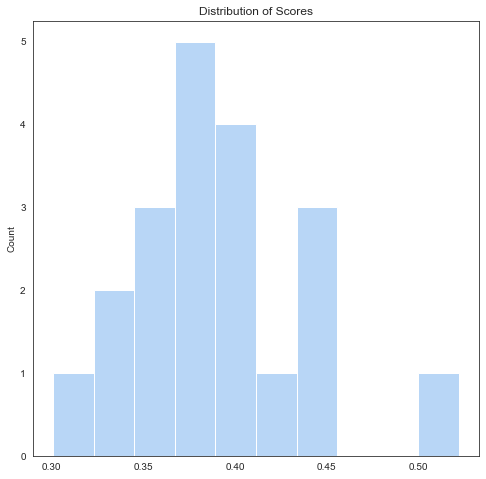

In [118]:
display_scores(sc)

This is our baseline. Our dumb model scored an average of about 0.4, so any that perform better than that have proven to be relatively effective.

### 4.1.2: Lasso and Ridge

L1 vs L2 based weight size costs added onto the cost function

In [119]:
from sklearn.linear_model import Ridge, LassoLars

In [120]:
lasso = LassoLars(alpha = 0.5)
sc = get_cross_val_scores(lasso)

describe_scores(sc)

Scores:  [0.35884323 0.40693787 0.40917691 0.45093457 0.37104852 0.33895048
 0.33506763 0.38433843 0.30078732 0.52205722 0.35761072 0.40891698
 0.35849155 0.45353814 0.38277261 0.3743407  0.44723988 0.42108538
 0.36785282 0.40172405] 

Mean score:  0.3925857504916492 

Scores STD:  0.04910317216863322


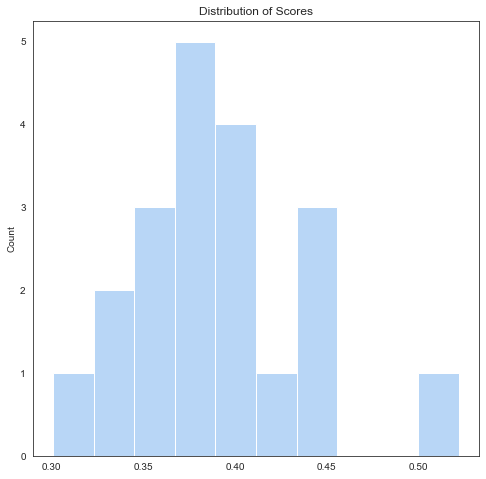

In [121]:
display_scores(sc)

LassoLars seems to have the exact same scoring, meaning that it was not effective.

In [122]:
ridge = Ridge(alpha = 1)
sc = get_cross_val_scores(ridge)
describe_scores(sc)

Scores:  [0.11353468 0.14786938 0.16233572 0.15820103 0.14443921 0.13438181
 0.12571863 0.13679541 0.14666713 0.33304803 0.18774288 0.15462609
 0.13091076 0.17156938 0.12597228 0.12862394 0.1811868  0.12161518
 0.13188362 0.11980882] 

Mean score:  0.15284653813382965 

Scores STD:  0.045976065246195935


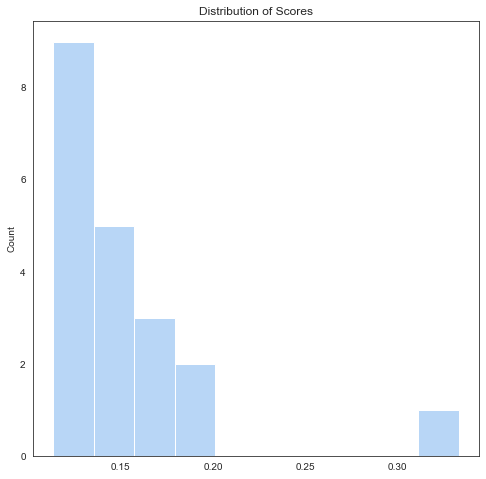

In [123]:
display_scores(sc)

Ridge seems to have performed quite well. An RMSE score of 0.15 is far less than the competition shown previously. 

### 4.1.3: KNN

In [124]:
knn = KNeighborsRegressor(n_neighbors=3)
sc = get_cross_val_scores(knn)
describe_scores(sc)

Scores:  [0.13309119 0.17333341 0.2019239  0.20938794 0.16683172 0.14833649
 0.15276955 0.13756734 0.16253335 0.19909337 0.20658741 0.21668462
 0.14157853 0.16595277 0.15845271 0.14349368 0.27038968 0.1466211
 0.16286493 0.1602096 ] 

Mean score:  0.17288516537784307 

Scores STD:  0.03350919266014326


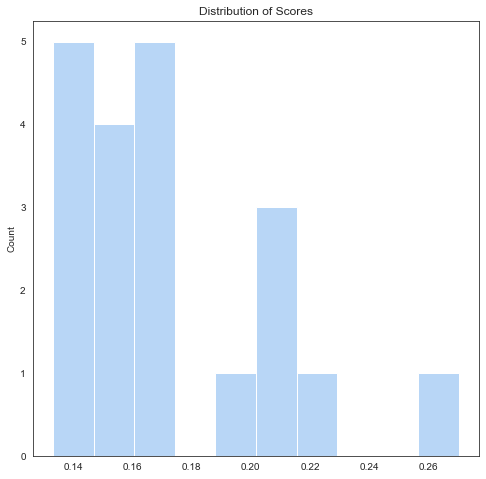

In [125]:
display_scores(sc)

It seems that the KNR model performed slightly worse than the Ridge regressor, but it did well overall.

### 4.1.4: Bayesian Ridge

In [126]:
bay = BayesianRidge()
sc = get_cross_val_scores(bay)
describe_scores(sc)

Scores:  [0.10997396 0.14713397 0.16571102 0.15516229 0.14308081 0.13020569
 0.12359242 0.13188063 0.14483932 0.33987057 0.1949106  0.15460831
 0.12748206 0.17018521 0.12704751 0.13242917 0.17860242 0.12458905
 0.12907042 0.11847131] 

Mean score:  0.15244233804304835 

Scores STD:  0.047953874683590435


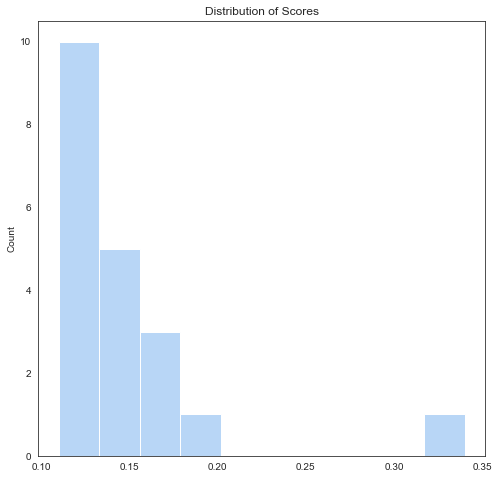

In [127]:
display_scores(sc)

Bayesian Ridge performed similarly to Ridge, meaning it did very well. 

### 4.1.5: Random Forest

In [128]:
rf = RandomForestRegressor(n_estimators=100)
sc = get_cross_val_scores(rf)
describe_scores(sc)

Scores:  [0.09741595 0.14988072 0.16932258 0.14597392 0.15657178 0.11787421
 0.12488585 0.1230724  0.15583516 0.16606363 0.16726757 0.16460834
 0.1330171  0.15940545 0.15347215 0.13939425 0.19488161 0.12198764
 0.11382173 0.09662425] 

Mean score:  0.14256881404120586 

Scores STD:  0.025242085275904817


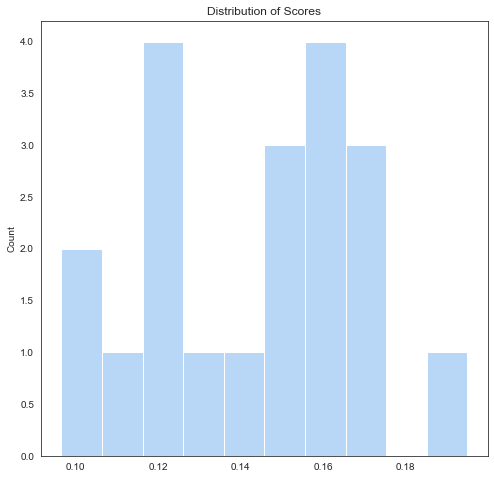

In [129]:
display_scores(sc)

The random forest model has performed the best so far with an average RMSE of 0.14.

### 4.1.6: SVM

In [130]:
from sklearn.svm import SVR
svm = SVR()
sc = get_cross_val_scores(svm)
describe_scores(sc)

Scores:  [0.10065268 0.13350037 0.14990467 0.15555066 0.13804853 0.11198599
 0.12048913 0.11792898 0.13201419 0.15253474 0.11987383 0.16027944
 0.11911372 0.1721972  0.12055574 0.13696738 0.26083653 0.11233385
 0.11793183 0.09991613] 

Mean score:  0.13663077958832992 

Scores STD:  0.034436705539262064


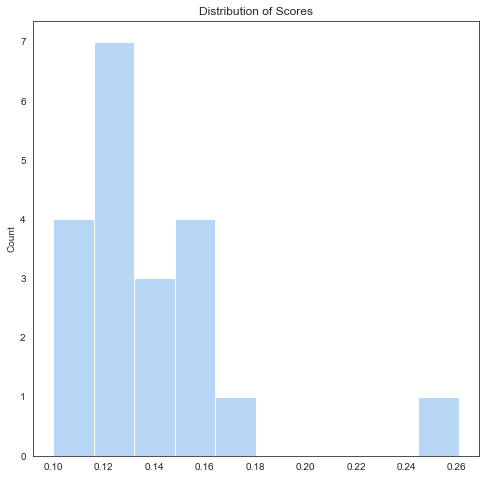

In [131]:
display_scores(sc)

Even better! The Support Vector Machine received a mean RMSE of 0.136. The standard deviation is a little bit larger than the Random Forest, but it performed in a respectable manner. 

### 4.1.7: GradientBoost

In [132]:
from sklearn.ensemble import GradientBoostingRegressor
boo = GradientBoostingRegressor()
sc = get_cross_val_scores(boo)
describe_scores(sc)

Scores:  [0.0931587  0.13655639 0.15706296 0.14083071 0.14659907 0.10916112
 0.10302618 0.1121816  0.14287334 0.14912865 0.15641492 0.16679491
 0.15057464 0.16093361 0.14276698 0.14017076 0.19088191 0.12379898
 0.11670346 0.08726861] 

Mean score:  0.13634437462886478 

Scores STD:  0.025668597718271777


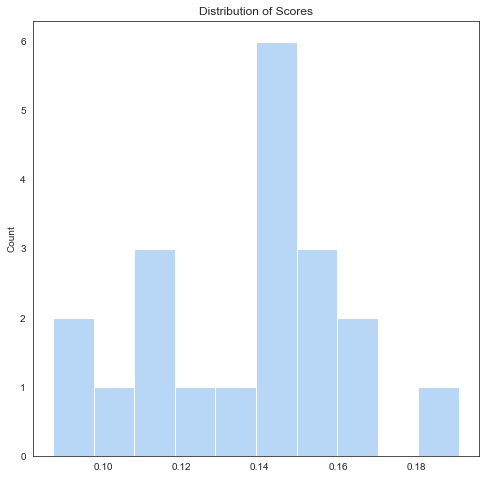

In [133]:
display_scores(sc)

Another model, another frontrunner.

### 4.1.8: Neural Network

In [134]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(40,40,40))

sc = get_cross_val_scores(nn)
describe_scores(sc)

Scores:  [0.2870989  0.47657597 0.44574405 0.2762882  0.29494671 0.34230154
 0.36677902 0.34138415 0.34294837 0.82691829 0.38366561 0.29464997
 0.43009721 0.31861467 0.41222504 0.3507937  0.79666215 0.39474543
 0.32811743 0.30788703] 

Mean score:  0.4009221731973593 

Scores STD:  0.14712162891798766


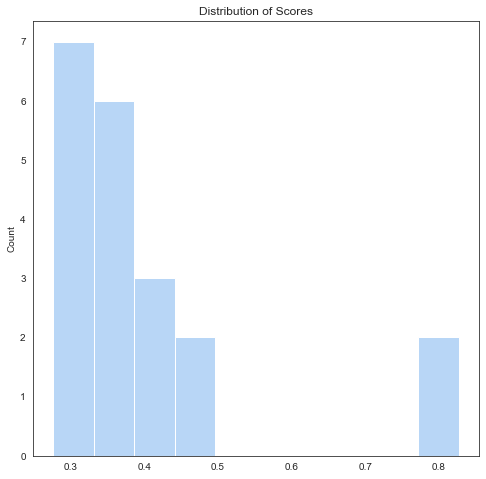

In [135]:
display_scores(sc)

A bit of a fun option. It didn't perform extremely well, but its hyperparameters could obviously be improved immensely. 

## 4.2: Fine-Tuning Promising Models

Chronologically, the most powerful models were Ridge, KNN, BayesianRidge, SVM, Random Forest, and Gradient Boost. We'll work with them below. 

In [136]:
from sklearn.model_selection import GridSearchCV
def grid_search_test(mod, paramgrid):
    grid_search = GridSearchCV(mod, paramgrid, scoring = 'neg_mean_squared_error', cv = 20, return_train_score = True)
    grid_search.fit(Xtrain, ytrain)
    
    print('Best Estimator Paramters: ', grid_search.best_params_, '\n')
    print('Best Evaluation Score: ', np.sqrt(np.abs(grid_search.best_score_)))

### 4.2.1: Ridge

In [137]:
paramgrid = [
    {'alpha': [0, 0.25, 0.5, 0.75, 1]}
]
grid_search_test(ridge, paramgrid)

Best Estimator Paramters:  {'alpha': 1} 

Best Evaluation Score:  0.15961159981348064


It seems the alpha parameter should be maxed out, meaning that the l2 weight cost should have full effect.

### 4.2.2: KNN

In [138]:
paramgrid = [
    {'n_neighbors': [3,4,5,6,7,8,9,10], 'weights':['uniform', 'distance']}
]
grid_search_test(knn, paramgrid)

Best Estimator Paramters:  {'n_neighbors': 5, 'weights': 'distance'} 

Best Evaluation Score:  0.16703946333471814


For this model, it looks like having five neighbors and for the them to be weighted by their distance from the test value.

### 4.2.3: SVM

In [139]:
paramgrid = [
    {'kernel':['linear','rbf'], 'C':[1,2,3,4,5], 'gamma':['scale','auto']}
    ]
grid_search_test(svm, paramgrid)

Best Estimator Paramters:  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} 

Best Evaluation Score:  0.13783335777579753


As suggested above, we'll run with the regularization function C at 1, a rbf nonlinear kernel, and an automatically adjusting gamma value. 

### 4.2.4: Random Forest

In [140]:
paramgrid = [
    {'n_estimators' : [50,100,150,200, 500], 'max_features' : [5,10,15,20, 25]}
]
grid_search_test(rf, paramgrid)

Best Estimator Paramters:  {'max_features': 15, 'n_estimators': 200} 

Best Evaluation Score:  0.13878929150480876


We'll stick with 20 features and 500 trees in the forest. 

### 4.2.5: Gradient Boost

In [141]:
paramgrid = [
    {'loss':['ls','lad','huber'], 'n_estimators':[75,100,150,200,500]}
]
grid_search_test(boo, paramgrid)

Best Estimator Paramters:  {'loss': 'lad', 'n_estimators': 500} 

Best Evaluation Score:  0.13411454375173584


We'll keep an l1 cost function and the 500 estimators.

## 4.3: Stacked Regressor

In [196]:
from sklearn.ensemble import StackingRegressor

base = [
    ('Ridge', Ridge()),
    ('KNN', KNeighborsRegressor(n_neighbors=5, weights = 'distance')),
    ('SVM', SVR(gamma = 'auto')),
    ('RandomForest', RandomForestRegressor(max_features=20, n_estimators=500))
]

reg = StackingRegressor(estimators = base, final_estimator=GradientBoostingRegressor(loss = 'lad', n_estimators=500), cv = 20)

reg.fit(Xtrain, ytrain)

StackingRegressor(cv=20,
                  estimators=[('Ridge', Ridge()),
                              ('KNN', KNeighborsRegressor(weights='distance')),
                              ('SVM', SVR(gamma='auto')),
                              ('RandomForest',
                               RandomForestRegressor(max_features=20,
                                                     n_estimators=500))],
                  final_estimator=GradientBoostingRegressor(loss='lad',
                                                            n_estimators=500))

In [197]:
yhat = reg.predict(Xval)
np.sqrt(mean_squared_error(yval, yhat))

0.12961413045250184

This is a great result, the best so far. From here, I'll compare the two after turning them back into their sales price counterparts. 

In [233]:
resized_original = np.exp(yval)
resized_results = np.exp(pd.Series(yhat))
resized_results.index = resized_original.index


quick_look = pd.concat((resized_original, resized_results, abs(resized_original['SalePrice'] - resized_results)), axis = 1)
quick_look.columns = ['ytrue','yhat','ydiff']

quick_look['ydiff'].describe()

count       292.000000
mean      17290.314514
std       26398.078706
min          18.288223
25%        5395.895697
50%       11390.294327
75%       20794.314602
max      352147.334974
Name: ydiff, dtype: float64

In [249]:
mean_squared_error(quick_look['ytrue'], quick_look['yhat'])

993427033.4395485

That's a lot of error; one reason for that is an outlier error where the model was off by about $350000, so the model is not performing as badly as described by that metric alone. With that being said, its variance could be far better. 

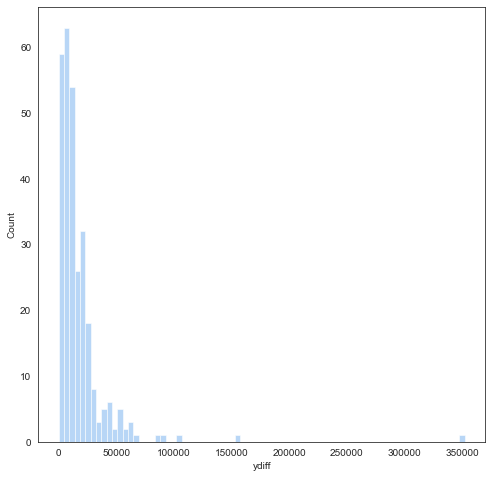

In [235]:
plt.figure(figsize=(8,8))
sns.histplot(x = quick_look['ydiff']);

## 5.0: Modeling the Test Set

In [236]:
Xtrain = full_pipeline(X, set_type='training')
ytrain = target_transformation(y, set_type='training')

Xtest = full_pipeline(pd.read_csv("./test.csv"))

Found 0 outliers!
Found 0 outliers!


In [244]:
reg.fit(Xtrain, ytrain)
yhat = reg.predict(Xtest)

In [273]:
kaggle = pd.concat((pd.Series(range(1461, len(yhat) + 1461)), pd.Series(np.exp(yhat))), names = ['Id','SalePrice'], axis = 1)
kaggle.columns = ['Id', 'SalePrice']

In [274]:
kaggle

Id      SalePrice
0     1461  128970.630878
1     1462  163167.393365
2     1463  174678.051072
3     1464  185465.113078
4     1465  184870.897829
...    ...            ...
1454  2915   85499.132179
1455  2916   89803.283256
1456  2917  166737.584720
1457  2918  111624.081852
1458  2919  206315.961413

[1459 rows x 2 columns]

In [275]:
kaggle.to_csv('kaggle_housing_predictions.csv')